In [196]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [197]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [198]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [199]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with = engine)


In [200]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [201]:
# Assign the measurement class to a variable called `Measurement` and
Measurement = Base.classes.measurement
# assign the station class to a variable called `Station`
Station = Base.classes.station
# Create a session
session = Session(engine)

In [202]:
#Check which Measurement's database columns
print(str(session.query(Measurement).statement))

SELECT measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs 
FROM measurement


# Exploratory Precipitation Analysis

In [203]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

In [204]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
one_year_ago = (dt.datetime.strptime(recent_date,'%Y-%m-%d')-dt.timedelta(days=365)).date()

# Perform a query to retrieve the data and precipitation scores
latest_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago ).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
latest_year_df = pd.DataFrame (latest_year,columns = ['Date','Precipitation'])

# Sort the dataframe by date
latest_year_df = latest_year_df.sort_values('Date').reset_index(drop=True)


In [205]:
latest_year_df

,Date,Precipitation
0,2016-08-23,0.0
1,2016-08-23,NaN
2,2016-08-23,45.5
3,2016-08-23,1.3
4,2016-08-23,3.8
...,...,...
2225,2017-08-22,0.0
2226,2017-08-23,0.0
2227,2017-08-23,0.0
2228,2017-08-23,2.0


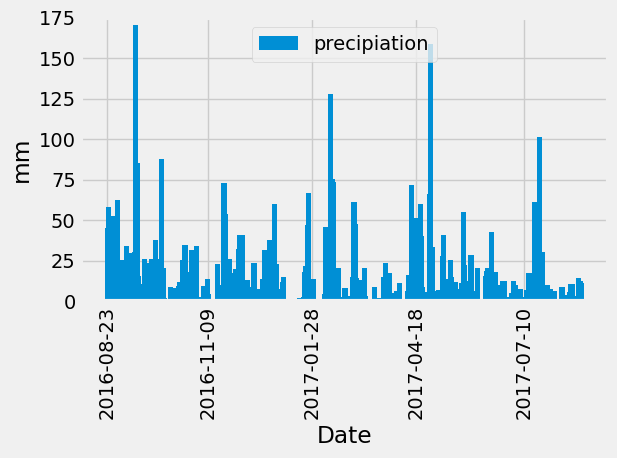

In [206]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(latest_year_df['Date'],latest_year_df['Precipitation'], label = 'precipiation', width=4)
plt.xlabel('Date')
plt.ylabel('mm')
plt.ylim(0,175)
plt.yticks(range(0,176,25))
plt.legend(loc='upper center')
x_label = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(x_label, rotation=90)
plt.tight_layout();

In [207]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary_states = pd.DataFrame(latest_year_df['Precipitation'].describe())
precipitation_summary_states

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [208]:
#Check which Station's database columns
Station_columns = print(str(session.query(Station).statement))

SELECT station.id, station.station, station.name, station.latitude, station.longitude, station.elevation 
FROM station


In [209]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [210]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [211]:
# Answer the following question: which station id has the greatest number of observations?
print(f"Station ID {most_active_station[0][0]} has the greatest number of observation")

Station ID USC00519281 has the greatest number of observation


In [212]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs) ).filter(Measurement.station == f'{most_active_station[0][0]}').all()



[(12.2, 29.4, 22.03582251082252)]

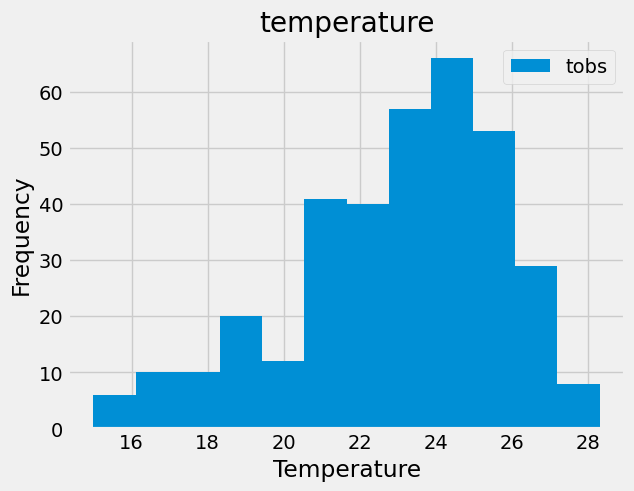

In [213]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_most_active_station = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago ).filter(Measurement.station == f'{most_active_station[0][0]}').all()
temp_most_active_station_df = pd.DataFrame(temp_most_active_station,columns = ['temperature'])
temp_most_active_station_df.hist(bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend();

# Close Session

In [214]:
# Close Session
session.close()
